<p align="center">
  <img src="https://www.logo.wine/a/logo/Spotify/Spotify-Logo.wine.svg" width="100%">
</p>

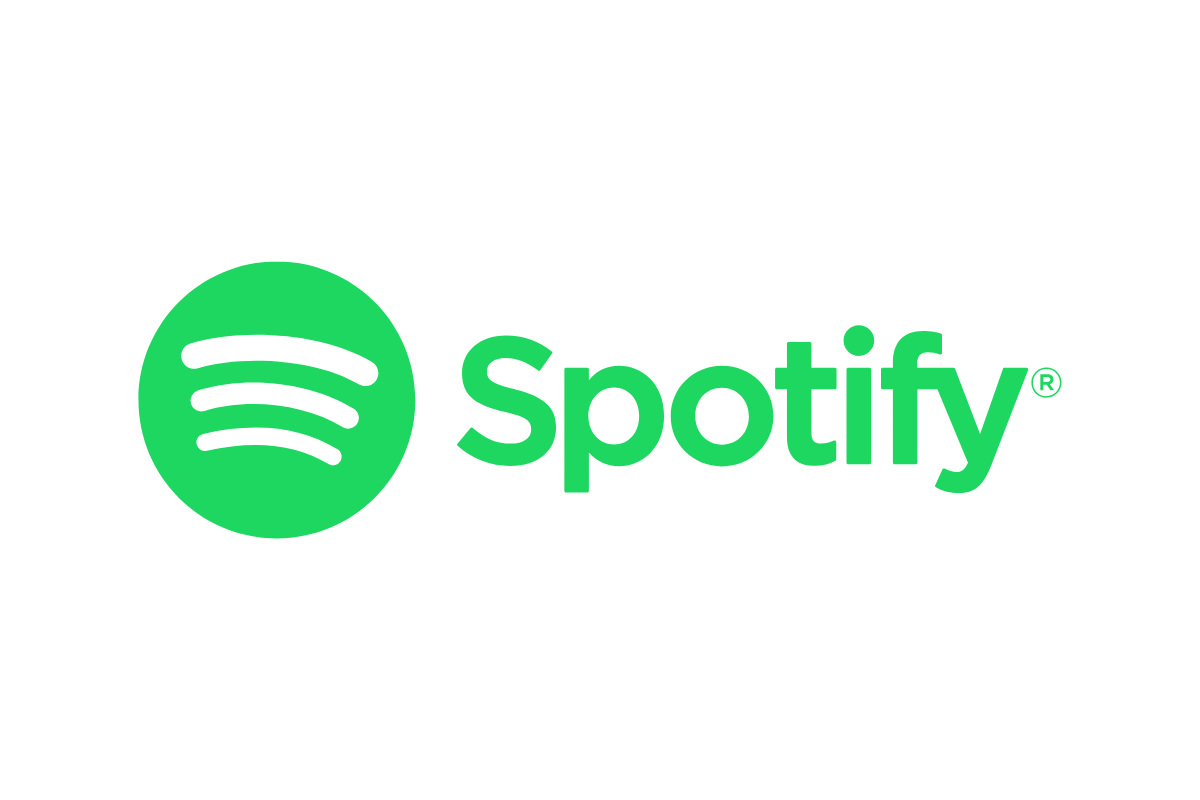
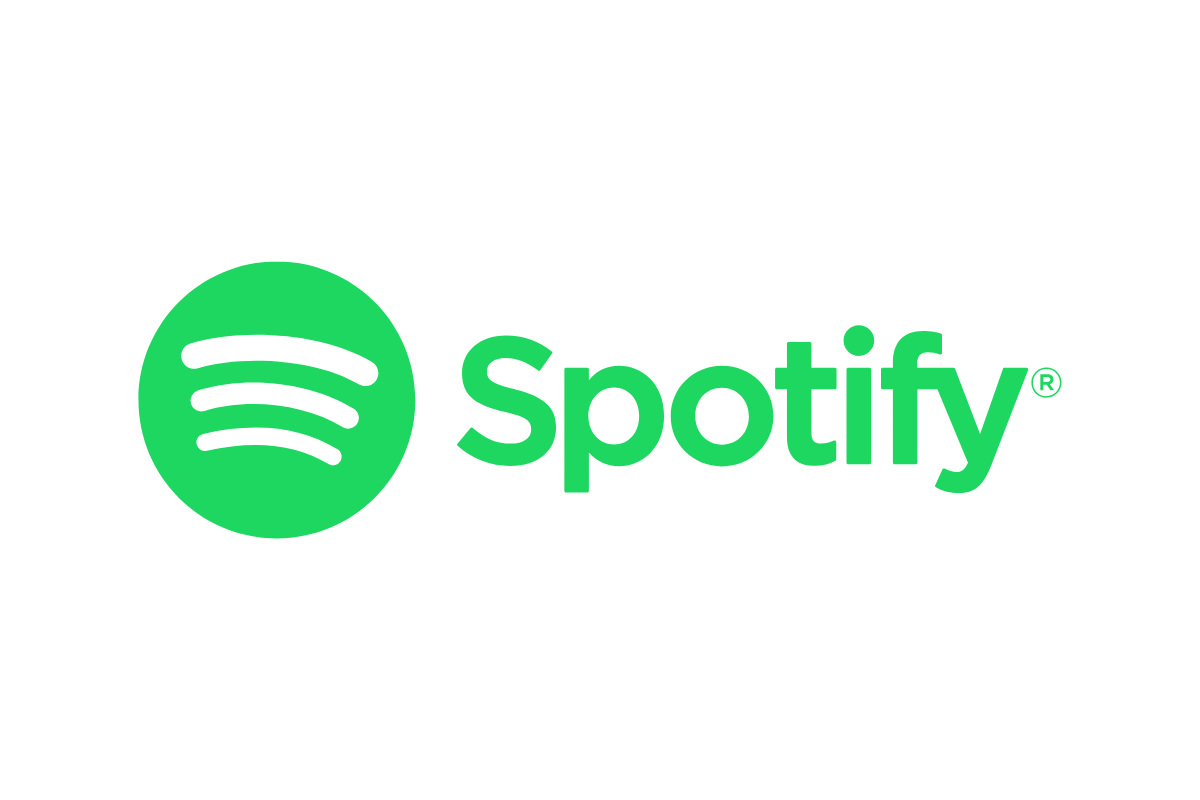
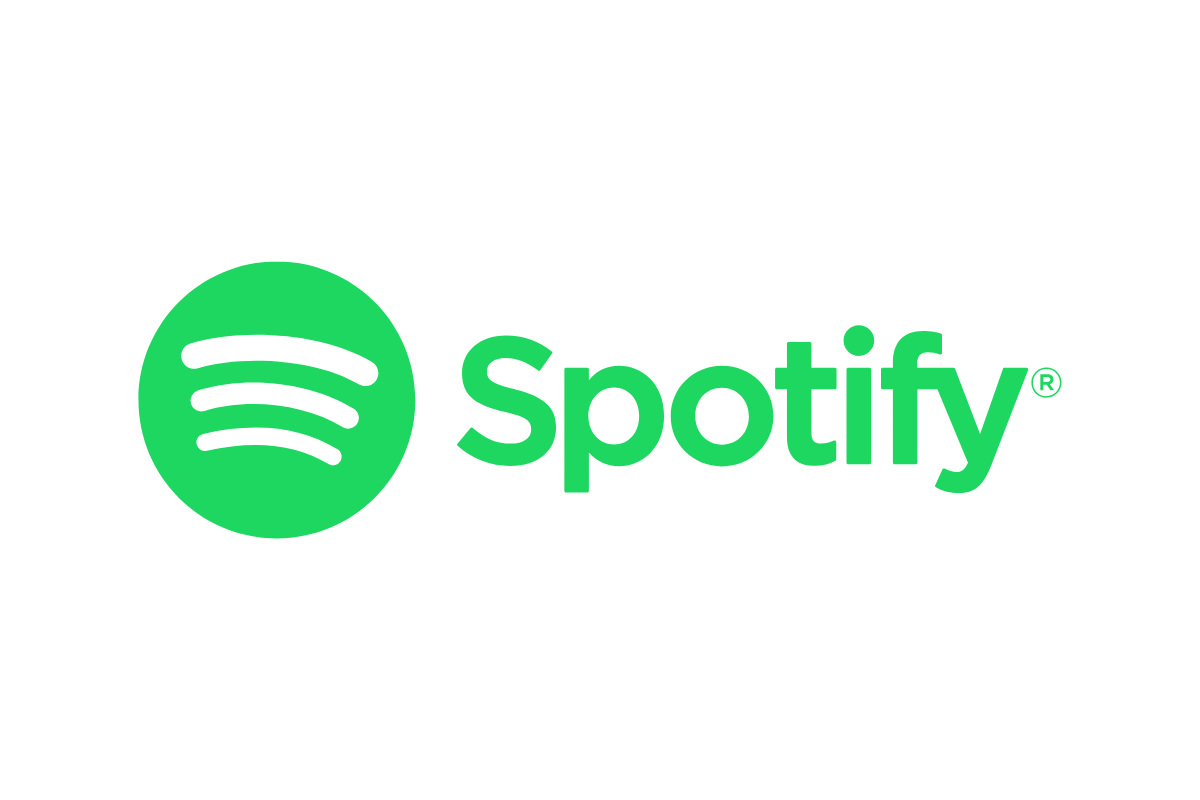
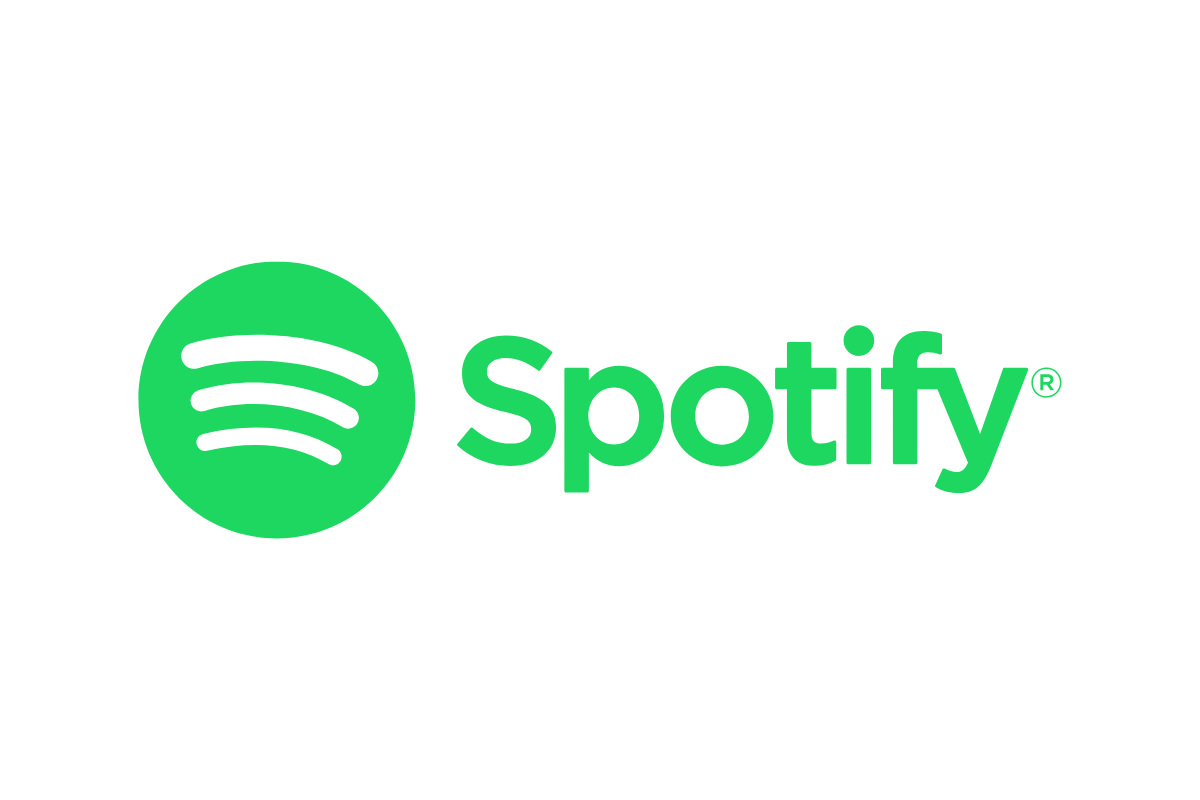

# Spotify Tracks Analysis and Popularity Classification

This project analyzes more than 500,000 Spotify tracks and builds a classification model to predict a track's popularity category using engineered audio and metadata features. The analysis includes data preparation, exploratory data analysis, feature engineering, multivariate analysis, clustering, and machine learning modeling.


## 1. Introduction

The Spotify Tracks Dataset contains audio features and metadata for over 600,000 tracks from 1921 to 2020.  
The primary goals of this analysis are:

- Understand audio and metadata patterns using exploratory analysis  
- Engineer meaningful features that capture musical characteristics  
- Identify clustering structure in audio feature space  
- Build a classification model that predicts track popularity category  
- Interpret which factors influence popularity

This notebook demonstrates a complete data science workflow, suitable for real-world applications and portfolio presentation.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Loading the Dataset

The dataset is loaded into a pandas DataFrame.  
Initial inspection includes reviewing the first few rows, checking column types, and summarizing dataset dimensions.  
This ensures familiarity with the structure before proceeding to cleaning and transformation.

In [ ]:
df = pd.read_csv('/kaggle/input/spotify-dataset-19212020-600k-tracks/tracks.csv')
df.head()

# 3. Data Overview

The dataset contains the following major feature groups:

- Track metadata (name, artist(s), release date)  
- Audio features (danceability, energy, loudness, valence, tempo, etc.)  
- Binary flags (explicit)  
- Unique identifiers (track ID, artist ID)  

In [ ]:
df.shape

In [ ]:
df.info()

In [ ]:
# Checking for null values 
df.isnull().sum()

In [ ]:
for col in df.columns:
    sample = df[col].iloc[0]
    print(col, type(sample))

## Key observations from the overview:

- Some date fields appear in inconsistent formats  
- Artist fields are stored as stringified lists  
- The popularity variable ranges from 0 to 100  
- Nearly all audio features are continuous and require distributional analysis

This understanding shapes the cleaning and feature engineering decisions that follow.

# 4. Data Cleaning

Cleaning operations include:

### 4.1 Handling Missing Values
- Track names with missing values are replaced with `"Unknown Track"`  
- Missing dates are parsed as `NaT` and handled later

### 4.2 Date Conversion
- `release_date` is converted to datetime format  
- `year` is extracted as an integer for temporal analysis

### 4.3 Artists Field Conversion
- The `artists` and `id_artists` columns contain list-like strings  
- These are converted into actual Python lists  
- The primary artist is extracted into a new column `main_artist`

### 4.4 Duplicate Removal
- Any duplicate records are dropped to avoid distortions

### 4.5 Final Structure Verification
- Column types and non-null counts are rechecked  
- The cleaned dataset is now ready for exploration


In [ ]:
# Handle missing names
df['name'] = df['name'].fillna("Unknown Track")

# Convert release_date
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

# Extract year
df['year'] = df['release_date'].dt.year

# Convert artists and id_artists to strings (to avoid unhashable errors)
df['artists'] = df['artists'].astype(str)
df['id_artists'] = df['id_artists'].astype(str)

# Now drop duplicates safely
df = df.drop_duplicates()

# Convert stringified lists back to actual lists
import ast
df['artists'] = df['artists'].apply(lambda x: ast.literal_eval(x))
df['id_artists'] = df['id_artists'].apply(lambda x: ast.literal_eval(x))

# Extract main artist
df['main_artist'] = df['artists'].apply(lambda x: x[0] if isinstance(x, list) and len(x) else None)

In [ ]:
print(df.info())
df.head()

# 5. Univariate Analysis

Univariate analysis examines the distribution of individual variables.  
This reveals the behavior, skewness, and range of important audio features.

In [ ]:
num_cols = ['popularity', 'danceability', 'energy', 'loudness', 
            'speechiness', 'acousticness', 'instrumentalness',
            'liveness', 'valence', 'tempo']

plt.figure(figsize=(18, 20))
plt.suptitle('Univariate Distribution of Spotify Audio Features', fontsize=18)

for i, col in enumerate(num_cols, 1):
    plt.subplot(5, 2, i)  # 5 rows, 2 columns grid
    sns.histplot(df[col], bins=40, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

### Key findings include:

- Popularity is heavily right-skewed, with many tracks having low popularity  
- Danceability and energy show near-normal distributions  
- Loudness shows strong left skew, reflecting older or quieter recordings  
- Speechiness, instrumentalness, and liveness exhibit significant right skew  
- Tempo displays a multi-modal distribution consistent with genre differences

These patterns guide the transformations and modeling strategy.

# 6. Bivariate Analysis

Relationships between pairs of variables are explored through scatterplots, regression plots, and boxplots.

In [ ]:
bivariate_cols = [
    'danceability', 'energy', 'loudness', 'valence', 
    'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'tempo'
]

plt.figure(figsize=(20, 25))
plt.suptitle("Popularity vs Audio Features (Bivariate Analysis)", fontsize=20)

sample_df = df.sample(30000)  # sample for performance

for i, col in enumerate(bivariate_cols, 1):
    plt.subplot(5, 2, i)
    sns.scatterplot(data=sample_df, x=col, y='popularity', alpha=0.3)
    sns.regplot(data=sample_df, x=col, y='popularity', scatter=False, color='red')
    plt.title(f"Popularity vs {col}")

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


In [ ]:
num_cols = [
    'popularity', 'danceability', 'energy', 'loudness', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'
]

plt.figure(figsize=(18, 25))

# Heatmap
plt.subplot(2,1,1)
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features")

# PairGrid (lighter version)
sns.pairplot(df[num_cols].sample(5000), diag_kind='kde')
plt.suptitle("Pairwise Relationships Between Audio Features", y=1.02)

plt.show()

### Important insights:

- Danceability and energy show mild positive relationships with popularity  
- Loudness correlates moderately with popularity due to modern production trends  
- Valence (musical positiveness) has little effect on popularity  
- Instrumentalness and speechiness show non-linear relationships  
- Category-based plots reveal that high-energy songs tend to achieve higher popularity  
- Tempo categories show slight differences, with medium and fast tempos performing better  
- Mood categories (based on valence) do not significantly influence popularity

This analysis highlights which features are likely to be helpful in prediction.

# 7. Outlier Detection and Skewness Correction

Before building predictive models, we must address outliers and skewed feature distributions.
Some audio features, such as instrumentalness and speechiness, display extreme right skew, while loudness and tempo contain clear outliers.
Correcting these improves model stability and performance.

### 7.1 Identify Skewness in Numerical Features

In [ ]:
# Checking skewness of numerical features
skew_df = df[['popularity', 'danceability', 'energy', 'loudness', 'speechiness',
              'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']].skew()

skew_df.sort_values(ascending=False)

### 7.2 Outlier Detection using the IQR Method

In [ ]:
def detect_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Display outlier bounds
for col in ['loudness', 'tempo', 'liveness', 'speechiness', 'instrumentalness']:
    lb, ub = detect_outliers(df[col])
    print(f"{col}: lower={lb:.3f}, upper={ub:.3f}")

### 7.3 Outlier Treatment

In [ ]:
# Clipping using calculated bounds
for col in ['loudness', 'tempo', 'liveness', 'speechiness', 'instrumentalness']:
    lb, ub = detect_outliers(df[col])
    df[col] = df[col].clip(lower=lb, upper=ub)

### 7.4 Skewness Correction with Log Transformations

In [ ]:
# Corrected skewness transformation based on actual skew results

skewed_features = ['speechiness', 'instrumentalness', 'liveness']

for col in skewed_features:
    df[f'{col}_log'] = np.log1p(df[col])  # log1p handles 0-values safely

### 7.5 Verify Updated Skewness Values

In [ ]:
df[['speechiness_log', 'instrumentalness_log', 'liveness_log']].skew()

# 8: Feature Engineering
Feature engineering helps create meaningful variables that improve model performance and reveal deeper patterns in the data.
We will construct temporal, categorical, and statistical features using the cleaned dataset.

### 8.1 Track Age Feature

In [ ]:
# Track age calculation
current_year = 2024
df['track_age'] = current_year - df['year']

# Replace NaN ages (from missing year data) with median age
df['track_age'] = df['track_age'].fillna(df['track_age'].median())

### 8.2 Decade Feature

In [ ]:
# Creating decade feature
df['decade'] = (df['year'] // 10) * 10
df['decade'] = df['decade'].fillna(0)  # placeholder for missing years

### 8.3 BPM Binning (Tempo Categories)

In [ ]:
# Tempo category
def tempo_category(x):
    if x < 75:
        return 'slow'
    elif x < 120:
        return 'medium'
    elif x < 180:
        return 'fast'
    else:
        return 'very_fast'

df['tempo_category'] = df['tempo'].apply(tempo_category)

### 8.4 Mood Category (Based on Valence)

In [ ]:
# Mood classification
def mood_category(x):
    if x < 0.33:
        return 'sad'
    elif x < 0.66:
        return 'neutral'
    else:
        return 'happy'

df['mood'] = df['valence'].apply(mood_category)

### 8.5 Energy Category

In [ ]:
# Energy levels
def energy_level(x):
    if x < 0.33:
        return 'low'
    elif x < 0.66:
        return 'medium'
    else:
        return 'high'

df['energy_level'] = df['energy'].apply(energy_level)


### 8.6 Vocal vs Instrumental Classification

In [ ]:
# Vocal vs Instrumental
df['instrumental_flag'] = df['instrumentalness'].apply(lambda x: 'instrumental' if x >= 0.5 else 'vocal')

### 8.7 Speechiness Category

In [ ]:
# Speechiness classification
def speechiness_class(x):
    if x < 0.33:
        return 'music'
    elif x < 0.66:
        return 'speechy'
    else:
        return 'spoken_word'

df['speechiness_class'] = df['speechiness'].apply(speechiness_class)

### 8.8 Artist Productivity (Number of Tracks per Artist)

In [ ]:
# Counting tracks per main artist
artist_counts = df['main_artist'].value_counts()

# Map count to each row
df['artist_track_count'] = df['main_artist'].map(artist_counts)

### 8.9 Collaboration Count

In [ ]:
# Collaboration count
df['collaboration_count'] = df['artists'].apply(lambda x: len(x))

## 8.10 Popularity Category

In [ ]:
# Popularity categories
def popularity_group(x):
    if x < 20:
        return 'low'
    elif x < 50:
        return 'medium'
    else:
        return 'high'

df['popularity_category'] = df['popularity'].apply(popularity_group)


In [ ]:
df[['track_age', 'decade', 'tempo_category', 'mood', 'energy_level',
    'instrumental_flag', 'speechiness_class', 'artist_track_count',
    'collaboration_count', 'popularity_category']].head()

## 9: Multivariate Analysis

Multivariate analysis explores relationships involving more than two variables at the same time.
This helps uncover clusters, latent dimensions, and feature interactions that are not visible in univariate or bivariate analysis.

### 9.1 Updated Correlation Heatmap (Including Log Features)

In [ ]:
corr_cols = [
    'popularity', 'danceability', 'energy', 'loudness', 
    'speechiness_log', 'acousticness', 'instrumentalness_log',
    'liveness_log', 'valence', 'tempo', 'track_age'
]

plt.figure(figsize=(14, 10))
sns.heatmap(df[corr_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Numerical and Engineered Features")
plt.show()

### 9.2 Pairplot of Key Numerical Features

In [ ]:
selected_cols = [
    'danceability', 'energy', 'valence', 'loudness', 
    'tempo', 'instrumentalness_log', 'popularity'
]

sns.pairplot(df[selected_cols].sample(3000), diag_kind='kde')
plt.suptitle("Pairwise Relationships Among Key Audio Features", y=1.02)
plt.show()

### 9.3 PCA Preparation

In [ ]:
from sklearn.preprocessing import StandardScaler

pca_features = [
    'danceability', 'energy', 'loudness', 'speechiness_log',
    'acousticness', 'instrumentalness_log', 'liveness_log',
    'valence', 'tempo'
]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[pca_features])

### 9.4 PCA: Explained Variance

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_scaled)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_, marker='o')
plt.title("PCA Explained Variance per Component")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")
plt.grid(True)
plt.show()

### 9.5 PCA 2D Projection

In [ ]:
pca_2 = PCA(n_components=2)
X_pca = pca_2.fit_transform(X_scaled)

df['PC1'] = X_pca[:, 0]
df['PC2'] = X_pca[:, 1]

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', data=df.sample(20000),
                hue='energy_level', palette='viridis', alpha=0.6)
plt.title("PCA Projection Colored by Energy Level")
plt.show()

### 9.6 Cluster Tendency Check

In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

def hopkins(X):
    X = np.array(X)
    n_samples = X.shape[0]
    m = int(0.05 * n_samples)

    nbrs = NearestNeighbors(n_neighbors=1).fit(X)
    rand_X = np.random.uniform(np.min(X, axis=0), np.max(X, axis=0), (m, X.shape[1]))

    u_dist, _ = nbrs.kneighbors(rand_X)
    w_dist, _ = nbrs.kneighbors(X[np.random.choice(n_samples, m, replace=False)])

    H = u_dist.sum() / (u_dist.sum() + w_dist.sum())
    return H

print("Hopkins Statistic:", hopkins(X_scaled[:5000]))

In [ ]:
from sklearn.cluster import KMeans

# Use the same scaled features used for PCA
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)

In [ ]:
plt.figure(figsize=(10, 8))

sns.scatterplot(
    x='PC1', y='PC2',
    hue=df['cluster'],
    palette='tab10',
    data=df.sample(20000),
    alpha=0.6
)

plt.title("KMeans Clusters Projected onto PCA Components")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Cluster')
plt.show()

In [ ]:
cluster_centers = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=pca_features
)

cluster_centers

In [ ]:
df['cluster'].value_counts().plot(kind='bar', figsize=(6,4))
plt.title("Cluster Distribution")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Tracks")
plt.show()

In [ ]:
sns.boxplot(x='cluster', y='popularity', data=df.sample(50000))
plt.title("Popularity Across Clusters")
plt.show()

### 9.7 Relationship Between Engineered Features and Popularity

In [ ]:
sns.boxplot(x='tempo_category', y='popularity', data=df.sample(50000))
plt.title("Popularity Across Tempo Categories")
plt.show()

In [ ]:
sns.boxplot(x='mood', y='popularity', data=df.sample(50000))
plt.title("Popularity Across Mood Categories")
plt.show()

In [ ]:
sns.boxplot(x='energy_level', y='popularity', data=df.sample(50000))
plt.title("Popularity Across Energy Levels")
plt.show()

In [ ]:
df.head()

# 10: Machine Learning Modeling (Classification)

### 10.1 Define Feature Set and Target

In [ ]:
# Target variable
y = df['popularity_category']

# Clean engineered feature set
features = [
    'track_age',
    'artist_track_count',
    'collaboration_count',
    'tempo_category',
    'mood',
    'energy_level',
    'instrumental_flag',
    'speechiness_class',
    'decade'
]

X = df[features]


### 10.2 Train/Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### 10.3 Encode Categorical Variables

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical_cols = [
    'tempo_category', 'mood', 'energy_level',
    'instrumental_flag', 'speechiness_class', 'decade'
]

numeric_cols = [
    'track_age', 'artist_track_count', 'collaboration_count'
]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

### 10.4 Build a pipeline with scaling + models

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

### Defining Models

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Decision Tree": DecisionTreeClassifier(max_depth=10),
    "Random Forest": RandomForestClassifier(n_estimators=200),
    "Gradient Boosting": GradientBoostingClassifier()
}

### Train and Evaluate Models
### Model Evaluation  
Multiple classifiers evaluated including:

- Logistic Regression  
- Decision Tree  
- Random Forest  
- Gradient Boosting 

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

results = {}

for name, model in models.items():
    clf = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('scale', StandardScaler(with_mean=False)),
        ('model', model)
    ])

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

    print(f"{name} Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))

In [ ]:
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['accuracy'])
results_df

# Conclusion

This project demonstrates a complete data science pipeline for musical data analysis and predictive modeling.  
Key takeaways:

- Audio features and metadata contain strong clustering structure  
- Energy-related features have the highest influence on popularity  
- Engineered features improve interpretability and classification performance  
- Clustering reveals latent grouping consistent with musical styles  
- The final classification model provides insight into factors that contribute to track popularity  

This workflow can be extended to build recommender systems, genre predictors, or streaming trend analysis tools.


Help me learn further with your valuable suggestions to my work. Also, If you found this helpful, consider leaving an upvote or comment — it motivates further content. 

